# 

# Numeric integration with Julia

To get started, we load the `MTH229` package:

In [0]:
using MTH229
using Plots
plotly()

### Quick background

Read more about this material here:
[integration](http://mth229.github.io/integration.html).

In many cases the task of evaluating a definite integral is made easy by
the fundamental theorem of calculus, one part of which states that for a
continuous function $f$ with (any) antiderivative, $F$, the definite
integral can be computed through:

$$
\int_a^b f(x) dx = F(b) - F(a).
$$

That is, the definite integral is found by evaluating a related function
at the endpoints, $a$ and $b$.

The `SymPy` package can compute many antiderivatives using a version of
the [Risch algorithm](http://en.wikipedia.org/wiki/Risch_algorithm) that
works for [elementary
functions](http://en.wikipedia.org/wiki/Elementary_function). `SymPy`’s
`integrate` function can be used to find an indefinite integral:

In [1]:
f(x) = x^2
@syms x
integrate(f(x), x)

 3
x 
──
3 

Or a definite integral by passing in values `a` and `b` through the
grouping `(x,a,b)`:

In [1]:
integrate(f(x), (x, 0, 1))      # returns a "symbolic" number

1/3

However, this only works *if* there is a known antiderivative
$F(x)$—which is not always the case. If not, what to do?

In this case, we can appeal to the *definition* of the definite
integral. For continuous non-negative $f(x)$, the definite integral is
the area under the graph of $f$ over the interval $[a,b]$. For possibly
negative functions, the indefinite integral is found by the *signed*
area under $f$. This area can be directly *approximated* using Riemann
sums, or some other approximation scheme.

The Riemann approximation for a definite integral uses approximating
rectangles. The following pattern will compute a Riemann sum with
equal-sized partitions using right-hand endpoints:

In [1]:
f(x) = x^2
a, b, n = 0, 1, 5       # 5 partitions of [0,1] requested
delta = (b - a)/n       # size of partition
xs = a .+ (1:n) * delta # a < x₁ < ⋯ < xₙ₋₁ < xₙ = b
sum(f.(xs)) * delta     # a new function `sum` to add up values in a container

0.44000000000000006

That value isn’t very close to $1/3$. But we only took $n=5$ rectangles
$-$ clearly there will be some error.


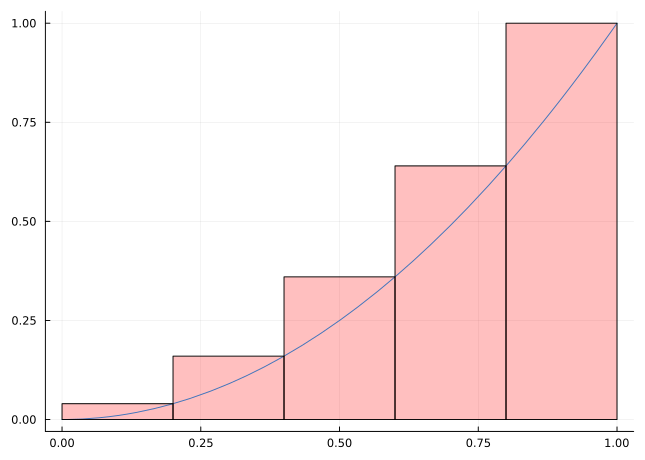

In [1]:
plot(f, a, b; legend=false)
riemann_plot!(f, a, b, n; fill=("red", 0.25, 0))

Bigger $n$s mean better approximations. This figure overlays the picture
with $n=10$.


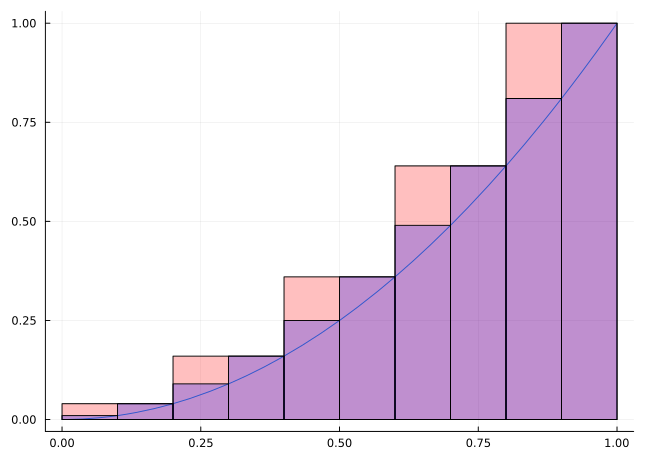

In [1]:
riemann_plot!(f, a, b, 10; fill=("blue", 0.25, 0))

With large `n` the figures become too crowded to illustrate, but we can
easily use a large value of `n` in our computations. With $n=50,000$ we
have the first $4$ decimal points are accurate:

In [1]:
f(x) = x^2
a, b, n = 0, 1, 50_000      # 50,000 partitions of [0,1] requested
delta = (b - a)/n
xs = a .+ (1:n) * delta
sum(f.(xs)) * delta

0.33334333340000005

Note that only the first two lines of the calculation needed changing to
adjust to a new problem.

------------------------------------------------------------------------

As the pattern is similar, it is fairly easy to wrap the computations in
a function for convenience. This is done for you in the `MTH229` package
with the `riemann` function. The above would be done through:

In [1]:
f(x) = x^2
a, b, n = 0, 1, 50_000
riemann(f, a, b, n)

0.33334333339999955

------------------------------------------------------------------------

The Riemann sum is slow to converge here. There are faster algorithms
both mathematically and computationally. We will briefly discuss two:
the [trapezoid](https://en.wikipedia.org/wiki/Trapezoidal_rule) rule,
which replaces rectangles with trapezoids; and
[Simpson’s](https://en.wikipedia.org/wiki/Simpson%27s_rule)rule which is
a quadratic approximation. Each is invoked by passing a value to the
`method` argument or `riemann`:

In [1]:
f(x) = x^2
riemann(f, 0, 1, 1000, method="trapezoid")

0.3333334999999997

And for Simpson’s method:

In [1]:
riemann(f, 0, 1, 1000, method="simpsons")

0.3333333333333334

------------------------------------------------------------------------

For real-world use, `Julia` has the `QuadGK` package and its function
`quadgk`, which is loaded with `MTH229`. By using a different approach
altogether, this function is much more efficient and estimates the
potential error in the approximation. It is used quite easily—no $n$ is
needed, as the algorithm is adaptive:

In [1]:
f(x) = x^2
answer, err = quadgk(f, 0, 1)

(0.3333333333333333, 0.0)

The `quadgk` function returns two values, an answer and an estimated
maximum possible error. The answer is the first number, clearly it is
$1/3$, and the estimated maximum error is the second. In this case it is
small ($10^{-17}$) $-$ basically `0`.

------------------------------------------------------------------------

In summary we consider here these functions to find definite integrals:

-   `integrate`—symbolically find a definite integral using the
    fundamental theorem of calculus, **if possible**.

-   `riemann`—approximate a definite integral using either Riemann sums
    or a related method.

-   `quadgk`—use Gauss quadrature approach to efficiently find
    approximations to definite integrals.

## Different interpretations of other integrals

The integral can represent other quantities besides the area under a
curve. We give two examples: arc-length and certain volumes of
revolution.

A formula to compute the length of the graph of a differentiable
function $f(x)$ from $a$ to $b$ is given by the formula:

$$
\int_a^b \sqrt{1 + f'(x)^2} dx
$$

That is, a function *related* to $f$ is integrated and this has a
different interpretation than the area under $f$.

For example, the arc-length of the square root function between $[0, 4]$
is given by:

In [1]:
f(x) = sqrt(x)
dL(x) = sqrt(1 + f'(x)^2)
answer, err = quadgk(dL, 0, 4)

(4.6467837188706085, 6.719391001417838e-8)

## Application: Volume of glasses.

We discuss an application of the integral to finding volumes—not areas.

A *solid of revolution* is a figure with rotational symmetry around some
axis, such as a soda can, a snow cone, a red solo cup, and other common
objects. A formula for the volume of an object with rotational symmetry
can be written in terms of an integral based on a function, $r(h)$,
which specifies the radius for various values of $h$.

> If the radius as a function of height is given by $r(h)$, the the
> volume is $\int_a^b \pi r(h)^2 dh$.

So for example, a baseball has a overall diameter of $2\cdot 37$mm, but
if we place the center at the origin, its rotational radius is given by
$r(h) = (37^2 - h^2)^{1/2}$ for $-37 \leq h \leq 37$. The volume in
mm$^3$ is given by:

In [1]:
r(h) = (37^2 - h^2)^(1/2)
dv(h) = pi * r(h)^2
answer, err = quadgk(dv, -37, 37)

(212174.79024304505, 0.0)

The volume in cubic inches, then is:

In [1]:
answer / (2.54 * 10)^3

12.947700103145083

------------------------------------------------------------------------

In [1]:
#  Your commands go here
